In [1]:
# ANALISI SHAP DI PRED = 0, PRED = 1

In [3]:
import torch
from transformers import AutoTokenizer

import shap
import nltk
import string
import pandas as pd
import matplotlib.pyplot as plt

from error_analysis_TRC import load_local_model
from TRC.utils_ea import create_token_dict, get_top_n


from better_profanity import profanity
from copy import deepcopy
from ast import literal_eval

/home/cc/venv/rora_venv/lib/python3.8/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/home/cc/venv/rora_venv/lib/python3.8/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimization_order(all_masks,

In [4]:
ASSIGN_WEIGHT = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = "cpu"
model_name = 'cardiffnlp/twitter-roberta-large-2022-154m'

model_path = '/home/cc/rora_tesi_new/log/log_TRC/twitter-roberta-large-2022-154m/bertweet-seq/20_epoch/data/True_weight/42_seed/saved-model/pytorch_model.bin'
config_path = '/home/cc/rora_tesi_new/log/log_TRC/twitter-roberta-large-2022-154m/bertweet-seq/20_epoch/data/True_weight/42_seed/saved-model/config.json'

In [5]:
tokenizer = AutoTokenizer.from_pretrained(model_name, normalization = True)
model = load_local_model(model_path, config_path, device, model_name)
model = model.to(device)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-large-2022-154m were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [6]:
# come input prende una lista di tweet
def f(x):
    # x = [tweet_test[0]]
    tv = torch.tensor([tokenizer.encode(v, padding='max_length', max_length=128, truncation=True) for v in x]).to(device)
    # print('tv',tv.shape)
    attention_mask = (tv!=0).type(torch.int64).to(device)
    # print('atte',attention_mask.shape)
    model.eval()
    with torch.no_grad():
        outputs = model(tv, attention_mask, class_weight=None)
    # print(outputs)

    return outputs['logits']

In [7]:
explainer = shap.Explainer(f, masker = tokenizer)

In [8]:
df_errati = pd.read_csv('/home/cc/rora_tesi_new/log/log_TRC/twitter-roberta-large-2022-154m/bertweet-seq/20_epoch/data/True_weight/42_seed/tweet_errati.csv', index_col = 0, converters={'Tweet tok':literal_eval})
df_corretti = pd.read_csv('/home/cc/rora_tesi_new/log/log_TRC/twitter-roberta-large-2022-154m/bertweet-seq/20_epoch/data/True_weight/42_seed/tweet_corretti.csv', index_col=0,  converters={'Tweet tok':literal_eval})
df_total = pd.concat([df_errati, df_corretti])

In [9]:
df_total.head()

,Tweet,Tweet tok,True label,Pred label
0,"@USER @USER that's not good, do you know what ...","[@USER, @USER, that's, not, good, ,, do, you, ...",1,0
1,Food poisoning in Mandeville HTTPURL,"[Food, poisoning, in, Mandeville, HTTPURL]",0,1
2,bel bev dabo food poison: HTTPURL via @USER,"[bel, bev, dabo, food, poison, :, HTTPURL, via...",0,1
3,Douno why my mum trusts me cooking the dinner....,"[Douno, why, my, mum, trusts, me, cooking, the...",0,1
4,"{Me,My Gist and I} A Couple Died of Food Poiso...","[{Me, ,, My, Gist, and, I}, A, Couple, Died, o...",0,1


In [10]:
df_pred_1 = df_total[(df_total['Pred label'] == 1 )]
df_pred_1 = df_pred_1.reset_index()
df_pred_0 = df_total[(df_total['Pred label'] == 0 )]
df_pred_0 = df_pred_0.reset_index()

In [11]:
tweet_pred_1 = df_pred_1['Tweet'].values.tolist()
tweet_pred_0 = df_pred_0['Tweet'].values.tolist()

In [12]:
tokens_pred_1 = df_pred_1['Tweet tok'].tolist()
tokens_pred_0 = df_pred_0['Tweet tok'].tolist()

In [13]:
def clean_strings(big_tokens_list):
    tags = ['@USER','USER', 'HTTPURL', 'HTTP', 'URL']
    nltk.download('stopwords')
    profanity.load_censor_words()
    stop_words = set(nltk.corpus.stopwords.words('english'))
    # idx_2be_removed = []
    clean_list = []
    for t_list in big_tokens_list:
        tokens = deepcopy(t_list)
        for token, i in zip(t_list, range(len(t_list))):
            tmp = deepcopy(token)
            tmp = tmp.strip()
            tmp = tmp.lower()
            if tmp in string.punctuation or \
            tmp.upper() in tags or \
            tmp == '...' or  tmp == '....' or \
            tmp in stop_words or \
            profanity.contains_profanity(tmp) or \
            len(tmp) < 3:
                # idx_2be_removed.append(i)
                tokens.remove(token)
        clean_list.append(' '.join(tokens))
        # print('dopo', tokens)
    # print(clean_list)
    # print(len(clean_list))
    return clean_list
        

In [14]:
clean_pred_1 = clean_strings(tokens_pred_1)
clean_pred_0 = clean_strings(tokens_pred_0)

[nltk_data] Downloading package stopwords to /home/cc/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


[nltk_data] Downloading package stopwords to /home/cc/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# SHAP FOR ALL DS

In [15]:
# all_tweets = df_total['Tweet'].tolist()
all_tweets_tokens = df_total['Tweet tok'].tolist()

In [16]:
cleaned_all = clean_strings(all_tweets_tokens)

[nltk_data] Downloading package stopwords to /home/cc/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [17]:
cleaned_all[:5]

["that's good know ate get food poisoning",
 'Food poisoning Mandeville',
 'bel bev dabo food poison via',
 'Douno mum trusts cooking dinner #foodpoisoning #notrust',
 '{Me Gist Couple Died Food Poison Rivers']

In [18]:
shap_values = explainer(cleaned_all)
shap_values.shape

Partition explainer: 413it [16:34,  2.46s/it]                         


(412, None, 2)

In [ ]:
# PLOT FOR CLASS 1

In [19]:
def token_dict(shap_values):
    # print('indice di shap preso: ', ind_to_get)
    token_dict_pos = {}
    token_dict_neg = {}
    nltk.download('stopwords')
    profanity.load_censor_words()
    stop_words = set(nltk.corpus.stopwords.words('english'))
    val = [shap_values[i] for i in range(len(shap_values))]
    for el in val:
        for i in range(len(el)-1):
            token = el[i].data
            # print(token)
            token = token.strip()
            if token not in string.punctuation and token != 'USER' and token != 'HTTPURL' and token != 'HTTP' and token!='URL' and token != '...' and len(token) >= 3:
                # print(token)
                shap_val = el[i].values
                # pos = abs(shap_val[0])
                # neg = abs(shap_val[1])
                pos = shap_val[1]
                neg = shap_val[0]
                token = token.lower()
                if token not in stop_words:
                    if not profanity.contains_profanity(token):
                        if (token not in token_dict_pos.keys()) or (token not in token_dict_neg.keys()):
                            token_dict_pos[token] = pos
                            token_dict_neg[token] = neg
                        else:
                            token_dict_pos[token] += pos
                            token_dict_neg[token] += neg
                            
    return token_dict_pos, token_dict_neg

In [21]:
token_dict_pos, token_dict_neg = token_dict(shap_values)

sorted_pos = sorted(token_dict_pos.items(), key = lambda x:x[1], reverse = True)
sorted_d_pos = dict(sorted_pos)

sorted_neg = sorted(token_dict_neg.items(), key = lambda x:x[1], reverse = True)
sorted_d_neg = dict(sorted_neg)

[nltk_data] Downloading package stopwords to /home/cc/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [31]:
to_plot_pos = get_top_n(40,sorted_d_pos)

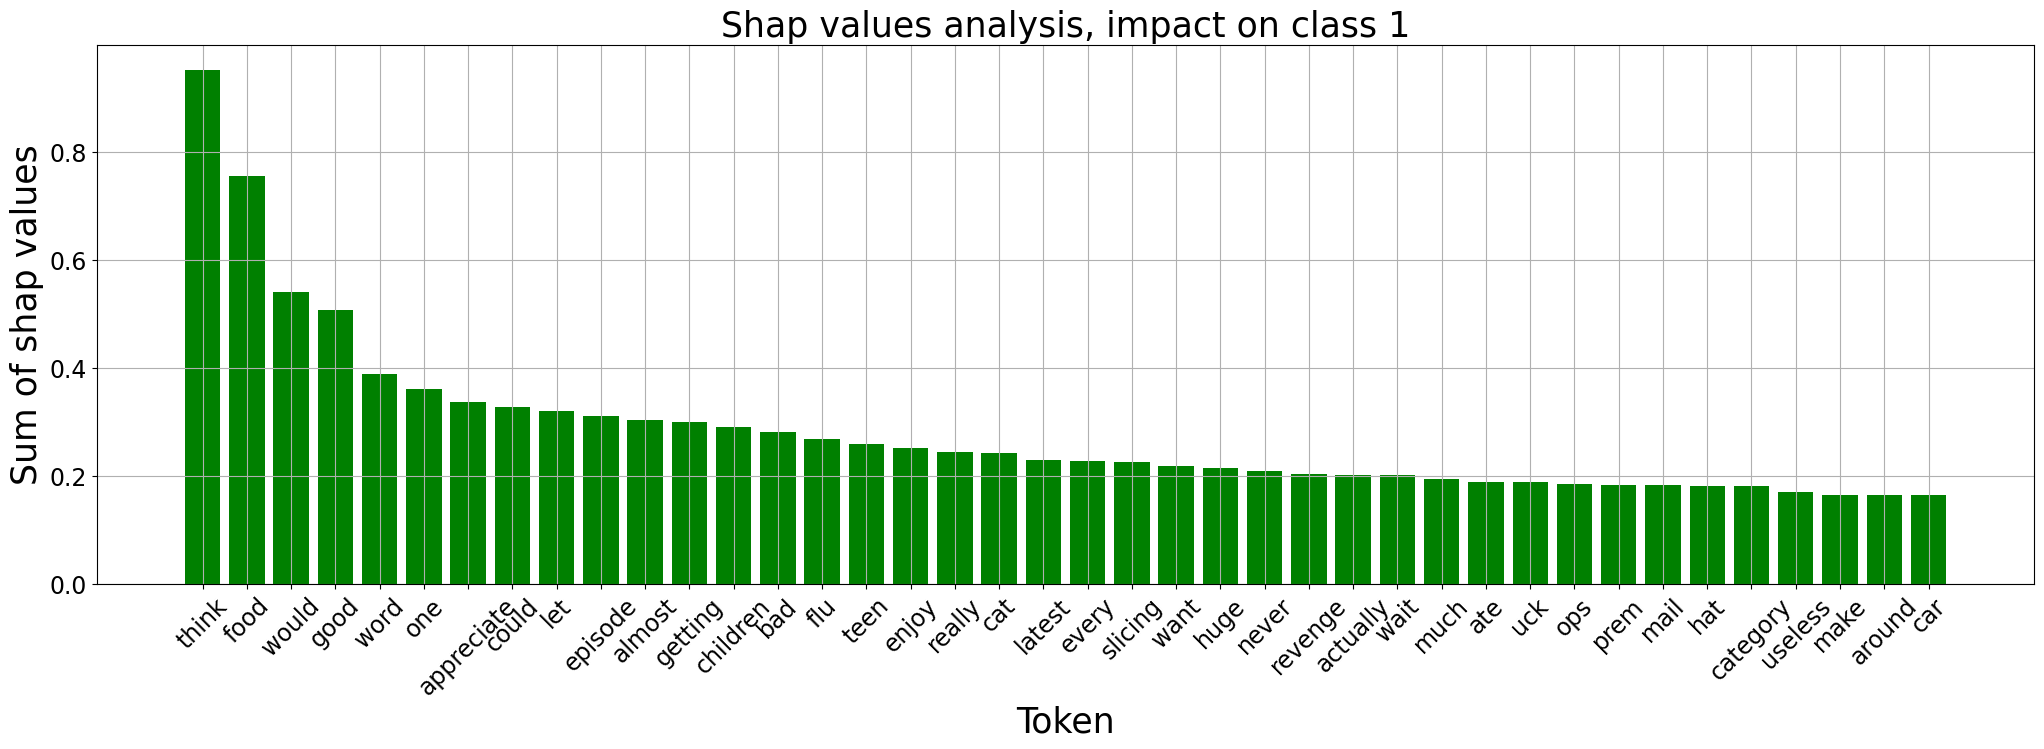

In [32]:
# CLASS 1
plt.figure(figsize=(25,7))
plt.bar(range(len(to_plot_pos)), list(to_plot_pos.values()), tick_label=list(to_plot_pos.keys()), color = 'green')
plt.xticks(fontsize=17, rotation = 45)
plt.yticks(fontsize=17)
plt.title('Shap values analysis, impact on class 1', fontsize = 25)
plt.xlabel('Token', fontsize = 25)
plt.ylabel('Sum of shap values', fontsize = 25)
plt.grid()
# plt.savefig('/home/cc/rora_tesi_new/log/log_TRC/twitter-roberta-large-2022-154m/bertweet-seq/20_epoch/data/True_weight/42_seed/shap/shap_pred_1.png',bbox_inches='tight')
plt.show()

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


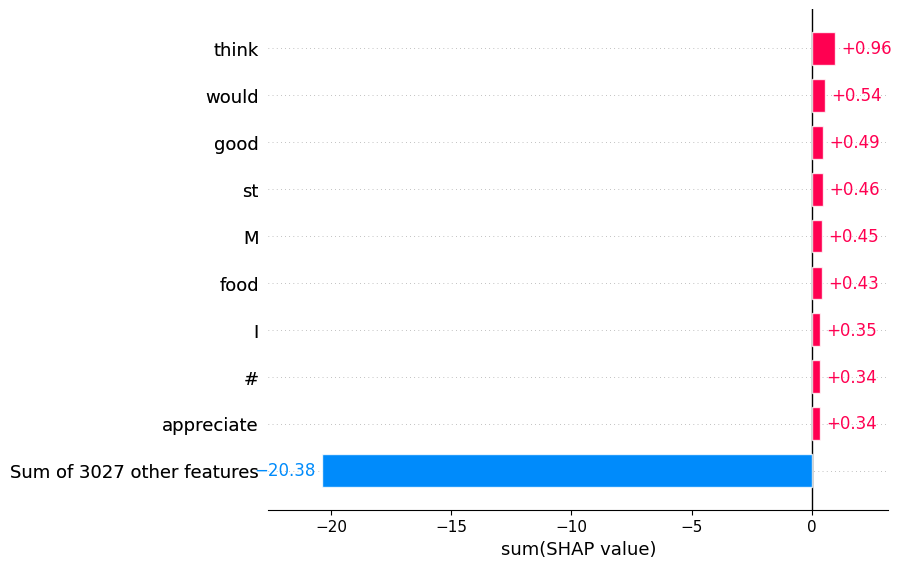

In [30]:
shap.plots.bar(shap_values[:,:,1].sum(0), order=shap.Explanation.argsort.flip)

In [33]:
to_plot_neg = get_top_n(40, sorted_d_neg)

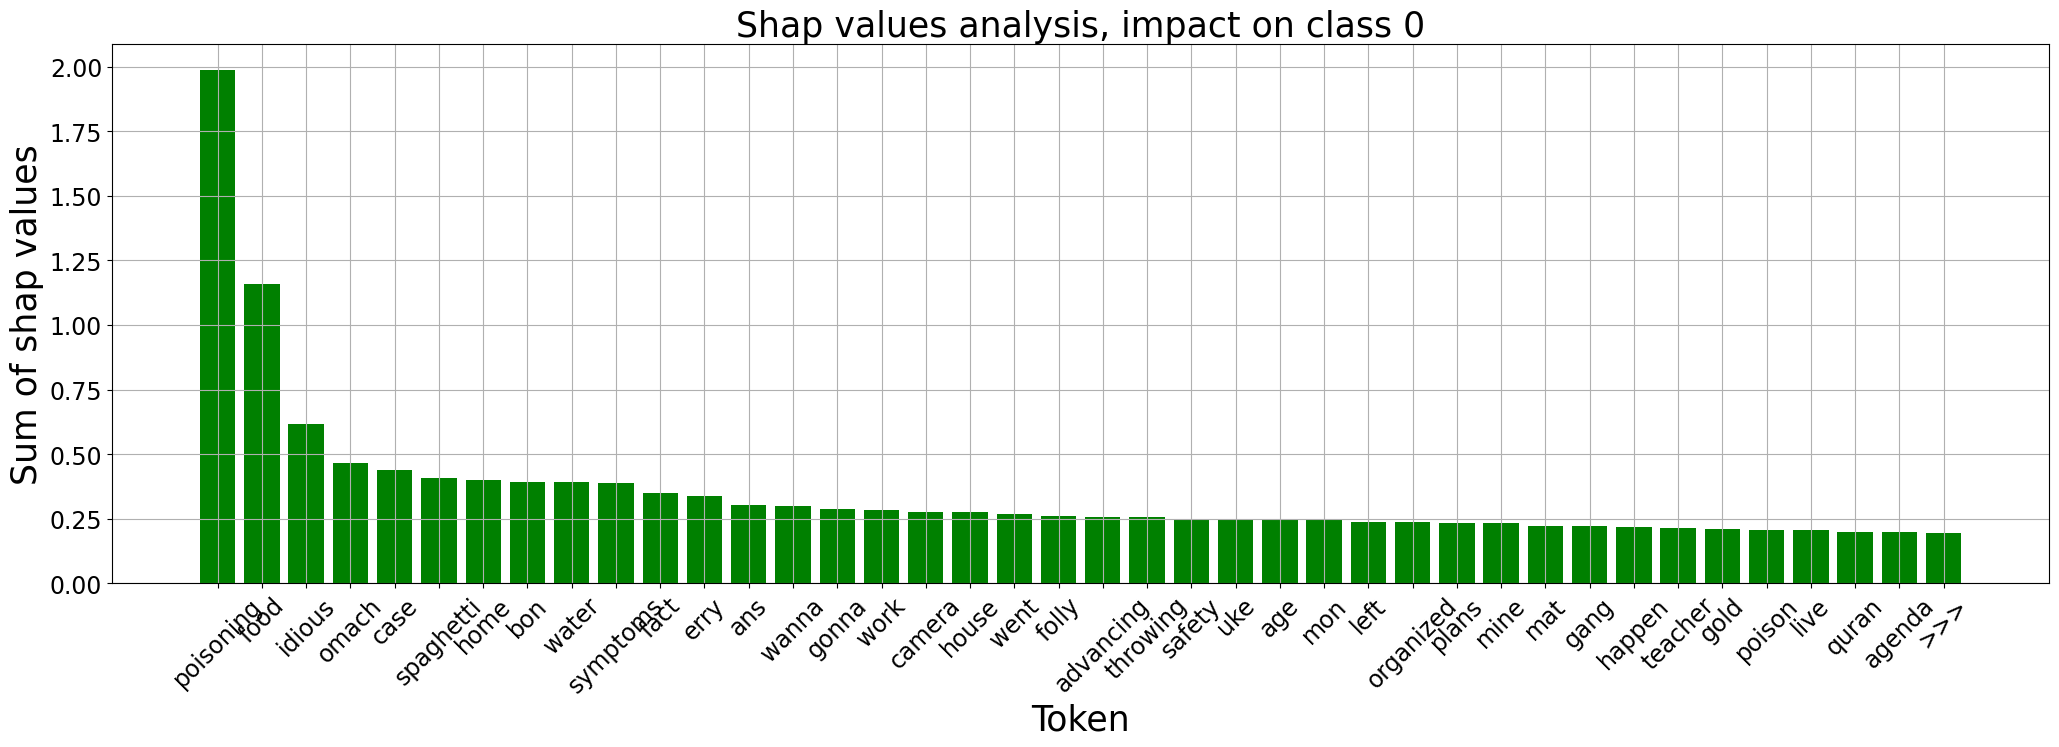

In [34]:
plt.figure(figsize=(25,7))
plt.bar(range(len(to_plot_neg)), list(to_plot_neg.values()), tick_label=list(to_plot_neg.keys()), color = 'green')
plt.xticks(fontsize=17, rotation = 45)
plt.yticks(fontsize=17)
plt.title('Shap values analysis, impact on class 0', fontsize = 25)
plt.xlabel('Token', fontsize = 25)
plt.ylabel('Sum of shap values', fontsize = 25)
plt.grid()
# plt.savefig('/home/cc/rora_tesi_new/log/log_TRC/twitter-roberta-large-2022-154m/bertweet-seq/20_epoch/data/True_weight/42_seed/shap/shap_pred_1.png',bbox_inches='tight')
plt.show()

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


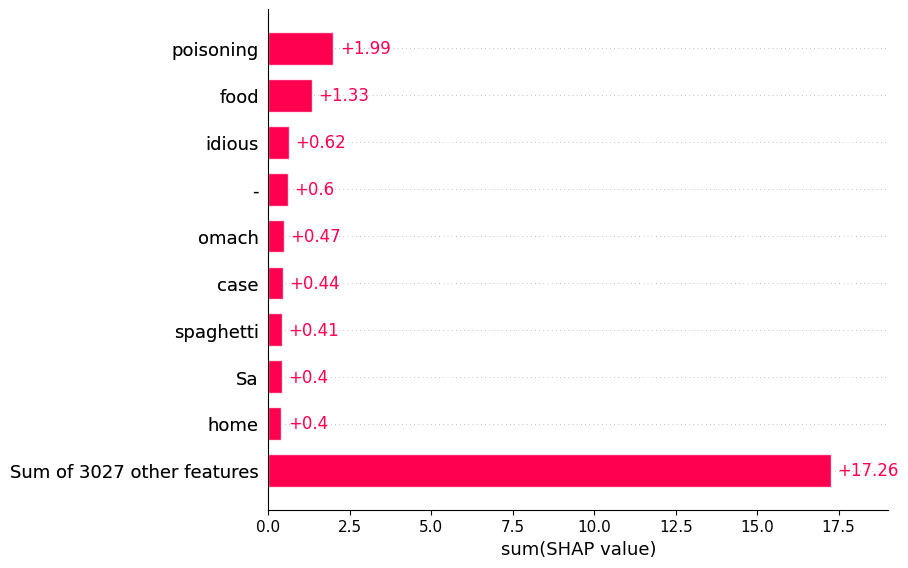

In [35]:
shap.plots.bar(shap_values[:,:,0].sum(0),  order=shap.Explanation.argsort.flip)

In [214]:
# CREATION OF SHAP VALUES FOR PRED = 1

In [215]:
shap_values = explainer(tweet_pred_1)
shap_values.shape

Partition explainer: 189it [12:03,  3.91s/it]                         


(188, None, 2)

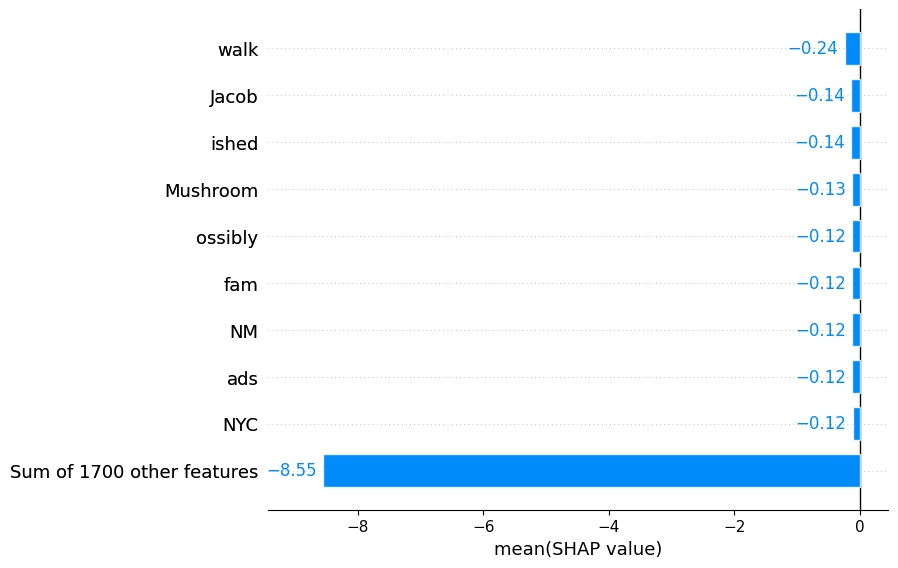

In [222]:
shap.plots.bar(shap_values[:,:,1].mean(0),  order=shap.Explanation.argsort)

In [58]:
token_dict = create_token_dict(shap_values, ind_to_get=1)
sorted = sorted(token_dict.items(), key = lambda x:x[1], reverse = True)
sorted_d = dict(sorted)

indice di shap preso:  1


[nltk_data] Downloading package stopwords to /home/cc/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [59]:
to_plot = get_top_n(20, sorted_d)

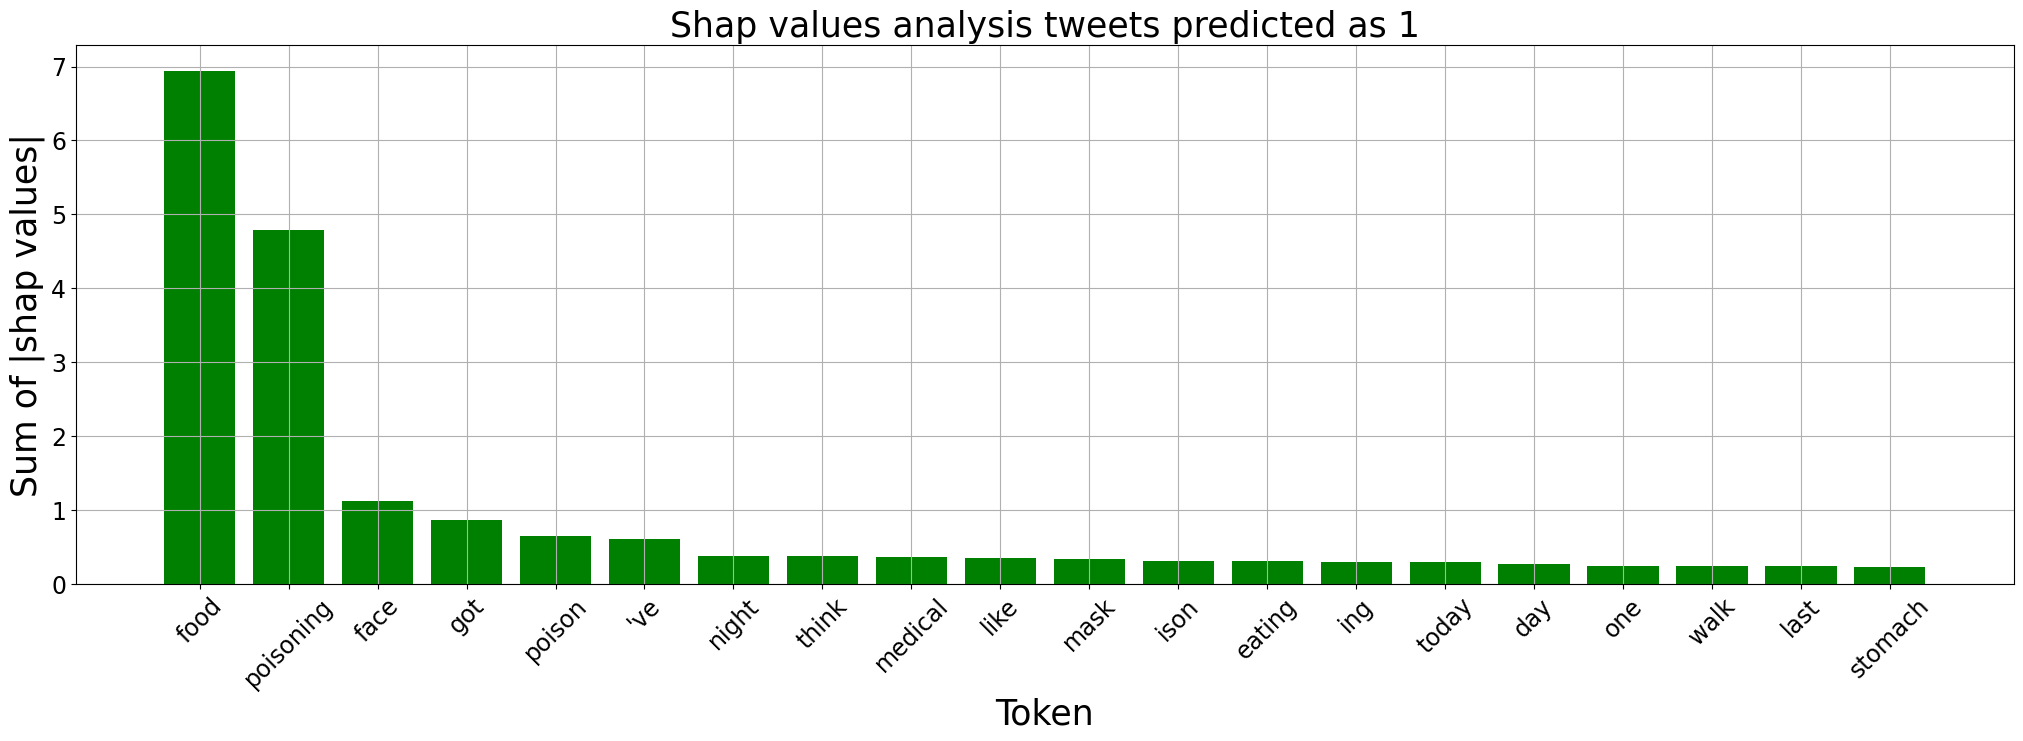

In [14]:
plt.figure(figsize=(25,7))
plt.bar(range(len(to_plot)), list(to_plot.values()), tick_label=list(to_plot.keys()), color = 'green')
plt.xticks(fontsize=17, rotation = 45)
plt.yticks(fontsize=17)
plt.title('Shap values analysis tweets predicted as 1', fontsize = 25)
plt.xlabel('Token', fontsize = 25)
plt.ylabel('Sum of |shap values|', fontsize = 25)
plt.grid()
plt.savefig('/home/cc/rora_tesi_new/log/log_TRC/twitter-roberta-large-2022-154m/bertweet-seq/20_epoch/data/True_weight/42_seed/shap/shap_pred_1.png',bbox_inches='tight')
plt.show()

In [10]:
# CREATION OF SHAP VALUES FOR PRED = 0

In [10]:
shap_values = explainer(tweet_pred_0)
shap_values.shape

Partition explainer: 225it [15:13,  4.10s/it]                         


(224, None, 2)

In [11]:
token_dict = create_token_dict(shap_values, ind_to_get=0)
sorted = sorted(token_dict.items(), key = lambda x:x[1], reverse = True)
sorted_d = dict(sorted)

indice di shap preso:  0


[nltk_data] Downloading package stopwords to /home/cc/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
to_plot = get_top_n(20, sorted_d)

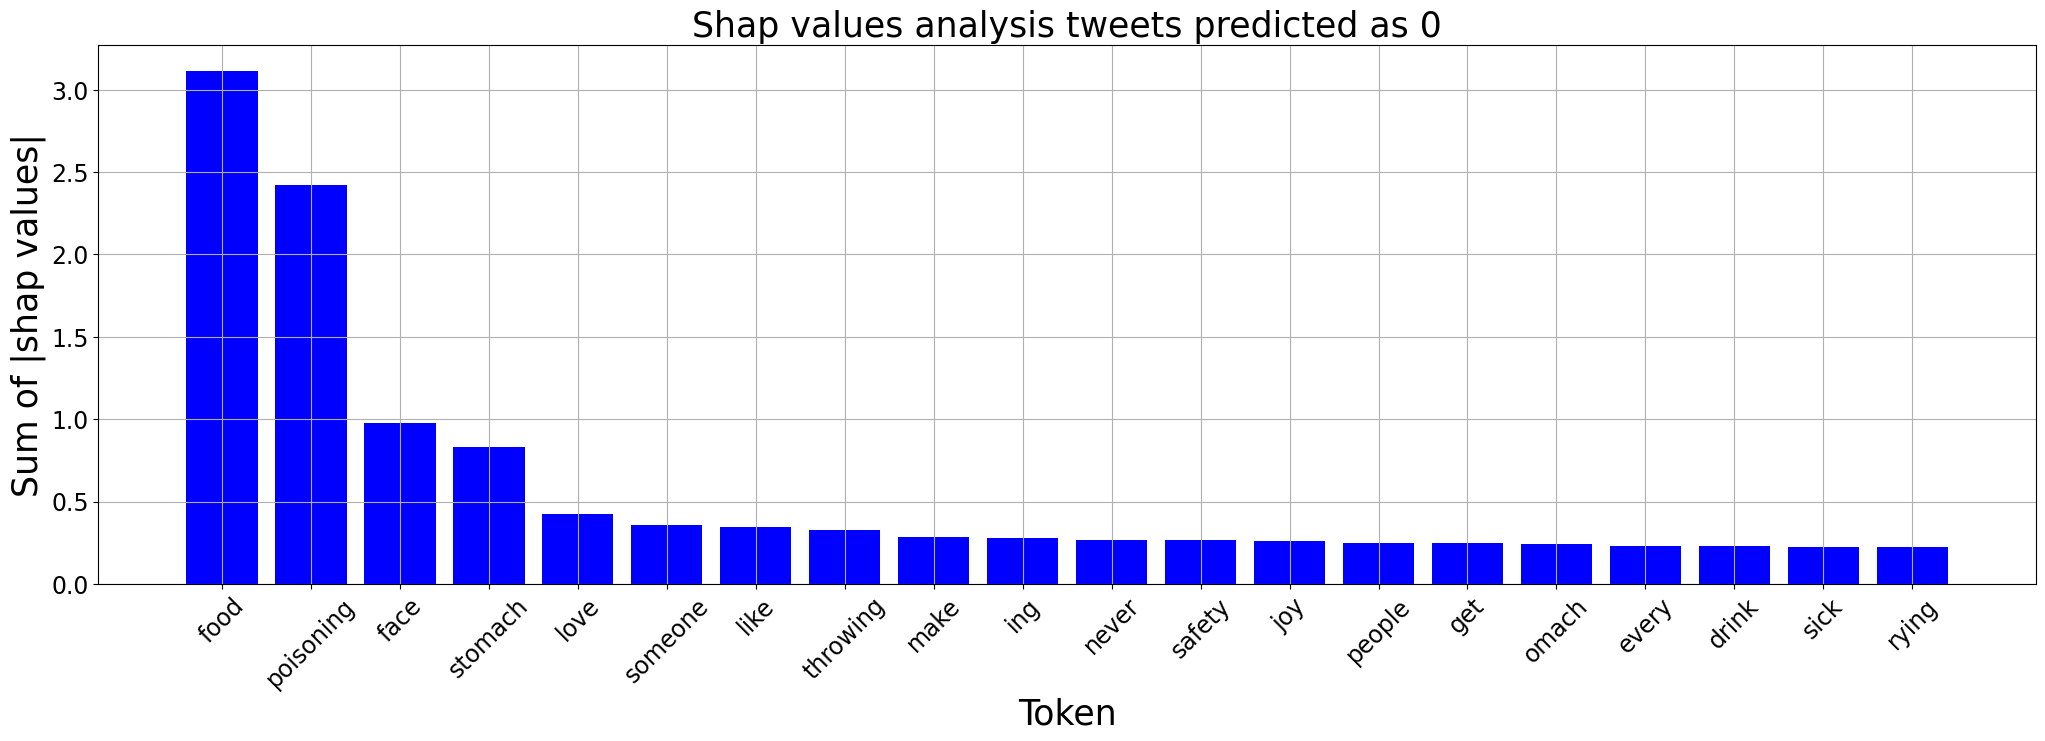

In [14]:
plt.figure(figsize=(25,7))
plt.bar(range(len(to_plot)), list(to_plot.values()), tick_label=list(to_plot.keys()), color = 'blue')
plt.xticks(fontsize=17, rotation = 45)
plt.yticks(fontsize=17)
plt.title('Shap values analysis tweets predicted as 0', fontsize = 25)
plt.xlabel('Token', fontsize = 25)
plt.ylabel('Sum of |shap values|', fontsize = 25)
plt.grid()
plt.savefig('/home/cc/rora_tesi_new/log/log_TRC/twitter-roberta-large-2022-154m/bertweet-seq/20_epoch/data/True_weight/42_seed/shap/shap_pred_0.png',bbox_inches='tight')
plt.show()